In [13]:
import os
import cx_Oracle
import pandas as pd
import numpy as np
import pickle
from datetime import date,datetime
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, cross_val_score 
import time
import matplotlib.pyplot as plt
from sklearn.utils import resample
import datetime

In [14]:
#connection = cx_Oracle.connect('HCIN_GUPTAN1[AP_UWI]/aGqQ4jnX92NG@INCL02.IN.PROD/HWIN_USR_DEV.HOMECREDIT.IN')
#cursor = connection.cursor()
#os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN")
#df=pd.read_pickle(os.getcwd()+"\\Data Files\\sql_data.pkl")
# qu1= """
# select * from TMP_BD_GRID_DISTANCE_ID
# where risk_agrf120 =1 
# """
#df = pd.read_sql(qu1,connection)
#df.to_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump.pkl")
#df.to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump.csv")

In [15]:
df = pd.read_pickle(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\data_dump.pkl")

In [16]:
df.head()

,SKP_CREDIT_CASE,TIME_DECISION_DATE,CUS_LAT,CUS_LONG,RISK_FSTQPD30,RISK_AGRF120,PRODUCT_GROUP,RISK_SCORE,RNK
0,154432501,2018-01-02,28.725803,77.175379,0,1,CD,0.027432,1
1,154536129,2018-01-01,25.313181,82.953024,1,1,CD,0.034592,1
2,154536988,2018-01-01,21.320343,72.868642,0,1,CD,0.042080,1
3,154545377,2018-01-01,22.690763,75.828938,0,1,CD,0.008329,1
4,154638596,2018-01-01,22.314938,70.834873,0,1,CD,0.071870,1


In [17]:
df.dropna(subset = ["RISK_SCORE"], inplace = True)

In [18]:
df["MONTH_STR"] = df["TIME_DECISION_DATE"].dt.strftime("%Y-%m")
df_summ = df.groupby("MONTH_STR").aggregate(["count","sum"])["RISK_FSTQPD30"]
df_summ["bad_rate"] = df_summ["sum"]/df_summ["count"]

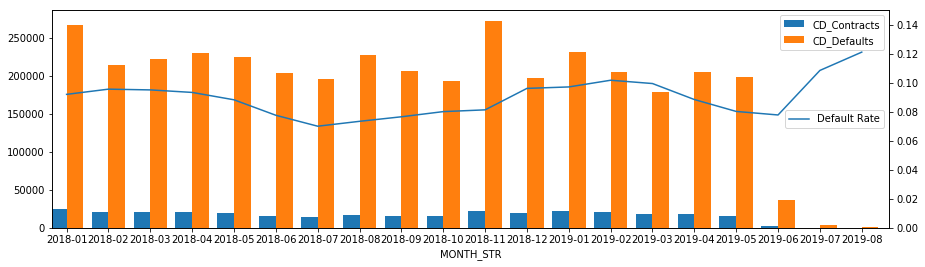

In [19]:
df_summ[['sum','count']].plot(kind='bar', width = 0.8, figsize=(15,4))
df_summ['bad_rate'].plot(secondary_y=True)

ax = plt.gca()
plt.xlim([-0.35, len(df_summ['sum'])-0.35])
ax.set_xticklabels(df_summ.index)
plt.ylim
fig = ax.get_figure()
ax = fig.get_axes()
ax[1].set_ylim(0,0.15)
ax[0].legend(['CD_Contracts','CD_Defaults'])
ax[1].legend(["Default Rate"], loc = "center right")


plt.show()


In [20]:
# Split Train and Test Data Set
df_train = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2018, 2, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 1, 31))]
df_test = df[(df["TIME_DECISION_DATE"]>=datetime.datetime(2019, 2, 1)) & 
              (df["TIME_DECISION_DATE"]<=datetime.datetime(2019, 3, 31))]

Random under-sampling:
1    224261
0    224261
Name: RISK_FSTQPD30, dtype: int64


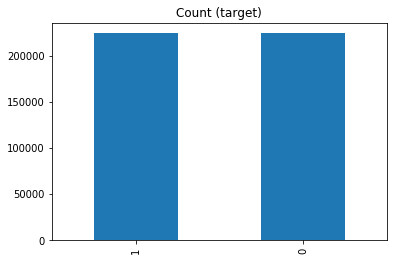

In [21]:
#Downsampling Code 
count_class_0, count_class_1 = df_train.RISK_FSTQPD30.value_counts()
df_class_0 = df_train[df_train['RISK_FSTQPD30'] == 0]
df_class_1 = df_train[df_train['RISK_FSTQPD30'] == 1]
df_class_0_under = df_class_0.sample(count_class_1)
df_train_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_train_under.RISK_FSTQPD30.value_counts())

df_train_under.RISK_FSTQPD30.value_counts().plot(kind='bar', title='Count (target)');

In [22]:
X_train = df_train_under[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]
X_test = df_test[["CUS_LAT","CUS_LONG","RISK_SCORE","TIME_DECISION_DATE"]]

y_train = df_train_under["RISK_FSTQPD30"]
y_test =  df_test["RISK_FSTQPD30"]


In [23]:
print("\nEvent rate in train set :", '{:,.2%}'.format(sum(y_train) / len(y_train)))

print("\nEvent rate in test set :", '{:,.2%}'.format(sum(y_test) / len(y_test)))

metric_auc_hcc_train = metrics.roc_auc_score(y_train, X_train['RISK_SCORE'])
gini_hcc_train = 2 * metric_auc_hcc_train - 1

metric_auc_hcc_test = metrics.roc_auc_score(y_test, X_test['RISK_SCORE'])
gini_hcc_test = 2 * metric_auc_hcc_test - 1

print("\nGini in train set :", '{:,.2%}'.format(gini_hcc_train))
print("\nGini in test set :", '{:,.2%}'.format(gini_hcc_test))


Event rate in train set : 50.00%

Event rate in test set : 10.08%

Gini in train set : 29.86%

Gini in test set : 25.02%


In [77]:
def gauss_x(sigma):
    def gauss(r):
        return pd.DataFrame(r).apply(lambda x: np.exp(-((x-0)**2)/(2*sigma**2))).to_numpy()
    gauss.__name__ = 'gauss_'+ str(sigma)
    return(gauss)

t=gauss_x(1)
#t([1,2,3])

'gauss_3'

In [78]:
tmp3 = [gauss_x(x) for x in np.arange(1,10)]
tmp3[2]([1,2,3])
tmp3[2].__name__



'gauss_3'

In [88]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors = 411, weights = t)
tmp = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

ypred_train = tmp.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
ypred_test = tmp.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]

In [89]:
metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)

gini_train = 2 * metric_auc_train - 1
gini_test = 2 * metric_auc_test - 1

print("GINI TRAIN:",'{:,.2%}'.format(gini_train))
print("\nGINI TEST:",'{:,.2%}'.format(gini_test))

GINI TRAIN: 15.73%

GINI TEST: 11.81%


In [131]:
param_grid = {# 'n_neighbors': 400,
              'weights' : [gauss_x(x) for x in np.exp(np.arange(0.00001,0.35,0.01))-1]
#              'weights' : [gauss_x(x) for x in np.exp(np.arange(0,3,0.01))-1]
            }
seed = 25

In [133]:
from sklearn.neighbors import KNeighborsClassifier
# Create KNN classifier
knn = KNeighborsClassifier(n_neighbors= 401)
kfolds = StratifiedKFold(4, random_state=1)

clf = RandomizedSearchCV(estimator=knn, param_distributions=param_grid, scoring=['roc_auc'], n_iter=5,
                         random_state=seed, cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train), refit='roc_auc',error_score=0, return_train_score =True)


In [134]:
print("Randomized search..")

search_time_start = time.time()
clf.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))
print("Randomized search time:", time.time() - search_time_start)

params = clf.best_params_   #get best parameters
dic=clf.cv_results_    #provides scoring results for each iteration, 50 in this case, mean values can be used 
tmp= pd.DataFrame(dic['params'])

Randomized search..
Randomized search time: 2119.705668926239


In [135]:
pd.DataFrame(dic).to_csv(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\Bigdata\Common Maps KNN\Common Maps-KNN_V4_Gaussian_Weghts_RCV_results_3.csv")

In [136]:
tmp1= pd.DataFrame(dic)[["param_weights","mean_test_roc_auc","mean_train_roc_auc"]]

In [137]:
tmp1['weights_name']=[x.__name__ for x in tmp1["param_weights"]]
tmp1

,param_weights,mean_test_roc_auc,mean_train_roc_auc,weights_name
0,<function gauss_x.<locals>.gauss at 0x000002A0...,0.550409,0.582327,gauss_0.18531670442814407
1,<function gauss_x.<locals>.gauss at 0x000002A0...,0.550877,0.580880,gauss_0.39098203821461364
2,<function gauss_x.<locals>.gauss at 0x000002A0...,0.550864,0.580920,gauss_0.377141535682457
3,<function gauss_x.<locals>.gauss at 0x000002A0...,0.549922,0.584869,gauss_0.1051819698400871
4,<function gauss_x.<locals>.gauss at 0x000002A0...,0.550350,0.582539,gauss_0.1735226061591959


In [126]:
print("Best score: {}".format(clf.best_score_))    #best auc score as we took that for refit 


print("Best params: ")

for param_name in sorted(params.keys()):
    print('%s: %r' % (param_name, params[param_name]))

Best score: 0.5512827819726307
Best params: 
weights: <function gauss_x.<locals>.gauss at 0x000002A0800DCB70>


In [ ]:
#update estimated hyperparameter values to new model
params = {'n_neighbors': 401,
         'weights': params['weight']}

knn = KNeighborsClassifier(**params)
# cross validation gini
auc_cv = cross_val_score(knn, X_train[["CUS_LAT","CUS_LONG"]], y_train, scoring='roc_auc', cv=kfolds.split(X_train[["CUS_LAT","CUS_LONG"]], y_train),
                         n_jobs=-1)
gini_cv = (2 * np.array(auc_cv) - 1).mean()


In [ ]:
bst = knn.fit(X_train[["CUS_LAT","CUS_LONG"]], np.ravel(y_train))

ypred_train = bst.predict_proba(X_train[["CUS_LAT","CUS_LONG"]])[:, 1]
ypred_test = bst.predict_proba(X_test[["CUS_LAT","CUS_LONG"]])[:, 1]

In [ ]:
metric_auc_train = metrics.roc_auc_score(y_train, ypred_train)
metric_auc_test = metrics.roc_auc_score(y_test, ypred_test)

gini_train = 2 * metric_auc_train - 1
gini_test = 2 * metric_auc_test - 1


In [1]:
print("GINI TRAIN:",'{:,.2%}'.format(gini_train))
print("\nGINI TEST:",'{:,.2%}'.format(gini_test))
print("\nGINI CV:",'{:,.2%}'.format(gini_cv))

NameError: name 'gini_train' is not defined